Transfer Learning with CNN


### GPU connection Check

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  1 18:03:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Libraries

In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs


# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

# Additional libraries
import numpy as np
import os
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import shutil

# torchvision imports
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder




%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Check memory availability

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


### Import Data

In [5]:
# !git clone https://github.com/jyassien/LPDI.git
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2670 (delta 23), reused 40 (delta 22), pack-reused 2628 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


## Load Model

In [ ]:
# from torchvision.models import ResNet18_Weights

# model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# num_classes = 8  # 8 variant classififcations of plants
# model.fc = nn.Linear(model.fc.in_features, num_classes)

In [6]:

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2024.11.10: Fast Qwen2_Vl vision patching. Transformers: 4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.90G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [7]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## Allocate GPU for the model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda


Load Data
=========


In [17]:
# Data augmentation and normalization for training
# Just normalization for
from torchvision import datasets, transforms
import os

from PIL import Image

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

    def __getitem__(self, index):
        # Get the original image and its label from ImageFolder
        image, label = super().__getitem__(index)

        # Get the folder name as the label (this is the directory name for the image)
        # The folder name corresponds to the class of the image
        folder_name = self.classes[label]  # Map the label index to its folder name

        return image, folder_name  # Return image and folder name as label

from torchvision import transforms
import torch
from torch.utils.data import DataLoader
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/PlantDoc-Dataset'

image_datasets = {x: CustomImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=20,
                              shuffle=True, num_workers=2)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Get class names (folder names in the root directory)
class_names = image_datasets['train'].classes

inputs, labels = next(iter(dataloaders['train']))

In [18]:
for i in range(2):
    image, label = image_datasets["train"][i]   # Get image and label
    print(f'Data {i}: Image: {image}, Label: {label}')



Data 0: Image: tensor([[[ 0.6734,  0.7248,  0.6734,  ..., -0.0972, -0.0972, -0.0801],
         [ 0.6049,  0.6906,  0.7077,  ..., -0.2171, -0.1999, -0.1486],
         [ 0.6049,  0.6049,  0.5878,  ..., -0.2856, -0.2342, -0.1828],
         ...,
         [-0.1486,  0.0398,  0.1254,  ...,  0.2111,  0.0569,  0.0056],
         [-0.1143,  0.0398, -0.0116,  ...,  0.2111,  0.1254,  0.0398],
         [-0.0972, -0.0458, -0.2171,  ...,  0.2453,  0.3481,  0.2796]],

        [[-0.4951, -0.5826, -0.6702,  ..., -0.0224, -0.0049,  0.0126],
         [-0.5301, -0.6001, -0.7052,  ..., -0.0574, -0.0574, -0.0399],
         [-0.6877, -0.6877, -0.6877,  ..., -0.1625, -0.1450, -0.1275],
         ...,
         [ 0.4328,  0.4853,  0.3803,  ...,  0.6779,  0.5728,  0.5553],
         [ 0.3803,  0.2402, -0.1625,  ...,  0.6604,  0.6254,  0.5553],
         [ 0.1352, -0.2325, -0.7402,  ...,  0.7479,  0.8529,  0.8004]],

        [[-0.0092, -0.0964, -0.2358,  ..., -1.1247, -1.1247, -1.1770],
         [-0.0790, -0.1138, -0

In [19]:
from torchvision.transforms import ToPILImage

instruction = "You are an expert plant diagnosis. Identify disease affected spots accurately on what you see in this image."

def format_to_conversation(image, label):
    image = ToPILImage()(image)

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": image},  # Image file reference
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": label},
            ],
        },
    ]

    return {"messages": conversation}

print("Done! ")

Done! 


In [33]:
# formatted_dataset_test = [
#     format_to_conversation(image, label)
#     for image, label in image_datasets['test']
# ]

In [39]:
image40, label40 = image_datasets['test'][40]
image40 = ToPILImage()(image40)

print(f"Actual: {image40}")
print(f"Actual: {label40}")


Actual: <PIL.Image.Image image mode=RGB size=224x224 at 0x7EFE4DEC8130>
Actual: Bell_pepper leaf spot


## Pre Trained

In [40]:
from torchvision.transforms import ToPILImage

FastVisionModel.for_inference(model) # Enable for inference!

# image, label = image_datasets['train'][0]
# image = ToPILImage()(image)

instruction = "You are an expert plant diagnosis. Identify disease affected spots accurately on what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image40,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Corn leaf<|im_end|>


## Finetune Model

In [41]:
formatted_dataset = [
    format_to_conversation(image, label)
    for image, label in image_datasets['train']
]

In [42]:
formatted_dataset[2]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert plant diagnosis. Identify disease affected spots accurately on what you see in this image.'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=224x224>}]},
  {'role': 'assistant',
   'content': [{'type': 'text', 'text': 'Apple Scab Leaf'}]}]}

In [43]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = formatted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [44]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,342 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,0.142600
2,0.113400
3,0.127800
4,0.124100
5,0.096000
6,0.147100
7,0.135000
8,0.135800
9,0.086900
10,0.142700


In [18]:
#@title Show final memory and time stats
# used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
# used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
# used_percentage = round(used_memory         /max_memory*100, 3)
# lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
# print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
# print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
# print(f"Peak reserved memory = {used_memory} GB.")
# print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
# print(f"Peak reserved memory % of max memory = {used_percentage} %.")
# print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

## After Pretrained

In [63]:
image50, label50 = image_datasets['test'][77]

image50 = ToPILImage()(image50)

print(f"Actual: {image50}")
print(f"Actual: {label50}")


Actual: <PIL.Image.Image image mode=RGB size=224x224 at 0x7EFE52C479D0>
Actual: Corn leaf blight


In [64]:
FastVisionModel.for_inference(model) # Enable for inference!

instruction = "You are an expert plant diagnosis. Identify disease affected spots accurately on what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Tomato leaf<|im_end|>


In [65]:
model.save_pretrained("lora_model2") # Local saving
tokenizer.save_pretrained("lora_model2")

[]

In [37]:
# model.save_pretrained_merged("unsloth_finetune", tokenizer,) # Save locally to 16bit

Unsloth: Merging QLoRA weights directly to the 16bit version of unsloth/qwen2-vl-7b-instruct.


added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [02:14<00:00, 33.61s/it]


In [39]:
# tokenizer.save_pretrained("unsloth_finetune")

[]

In [66]:
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "lora_model2", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model) # Enable for inference!

==((====))==  Unsloth 2024.11.10: Fast Qwen2_Vl vision patching. Transformers: 4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [67]:


# image, label = formatted_dataset['test'][12]
instruction = "You are an expert plant diagnosis. Identify disease affected spots accurately on what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
# if image.dtype == torch.bfloat16:
#     image = image.to(torch.float32)
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image50,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
#                    use_cache = True, temperature = 1.5, min_p = 0.1)

In [34]:
print(torch.cuda.get_device_properties(0))


_CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22699MB, multi_processor_count=58, uuid=e4225b1f-6812-f654-7dc3-e01fd5b759f1, L2_cache_size=48MB)


In [68]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Tomato leaf<|im_end|>


Examples of testing images:
======================

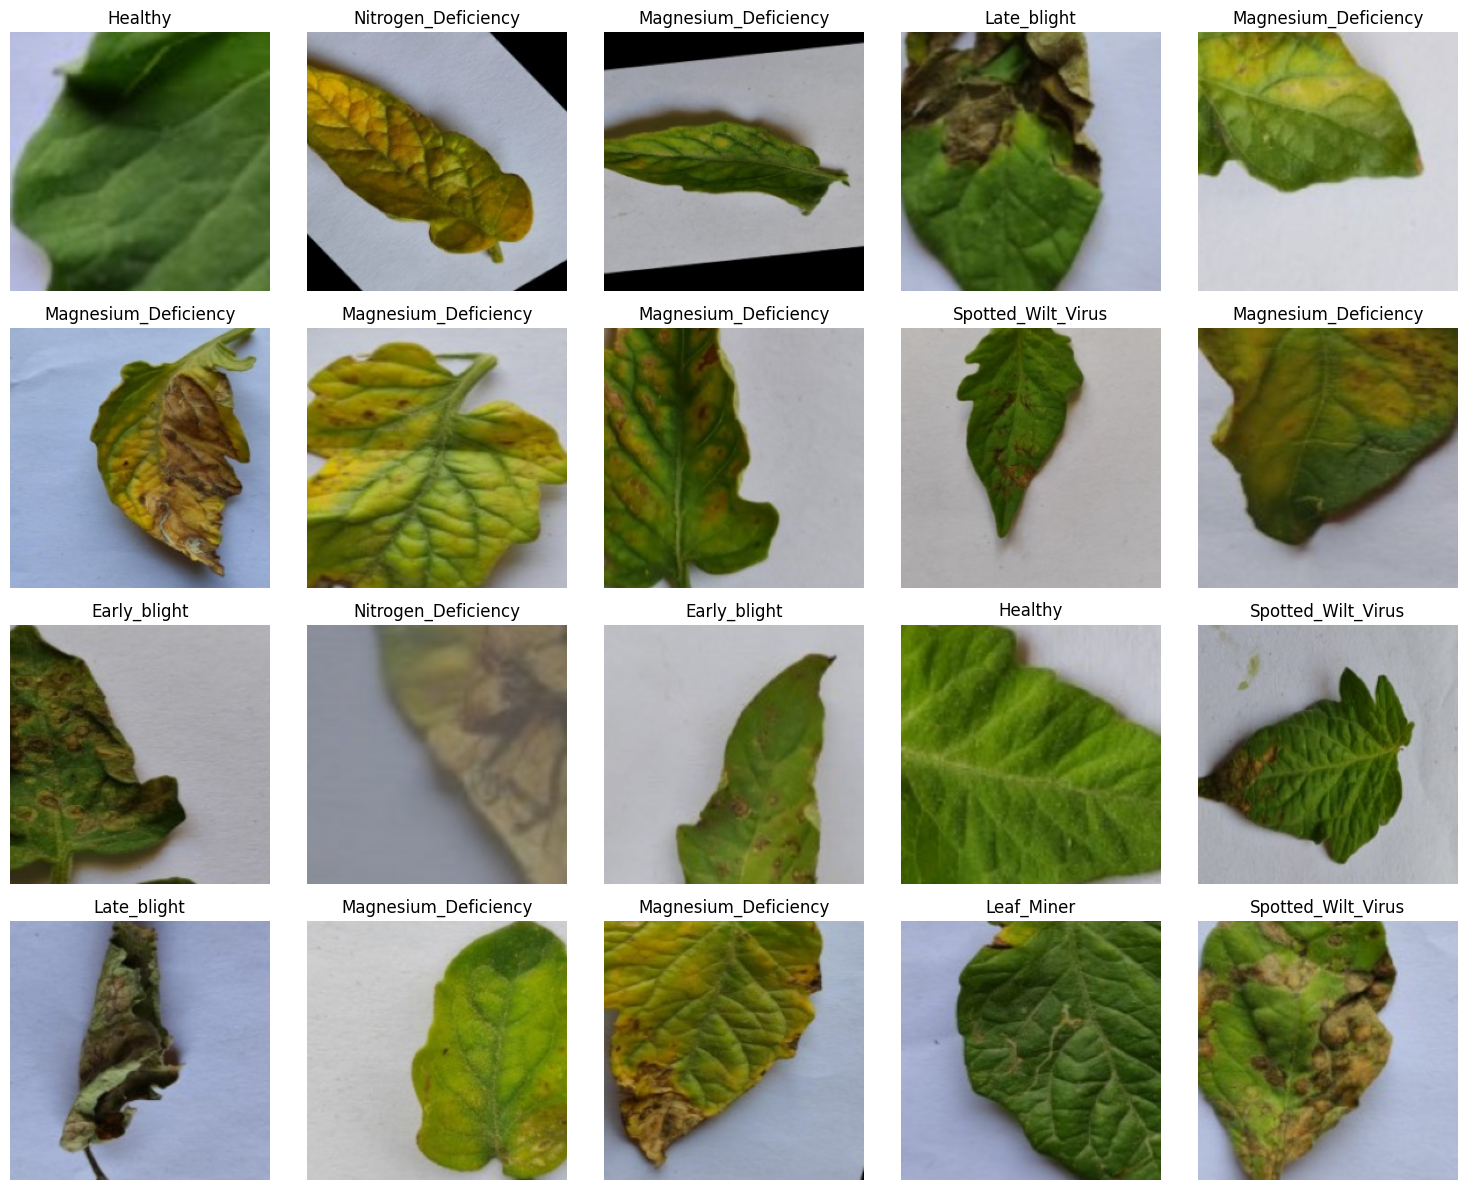

In [ ]:
def imshow_grid(inputs, classes, class_names, num_rows=4):
    """Display images in a grid with class names above each image."""
    batch_size = inputs.size(0)
    inputs = inputs.cpu()  # matplotlib compatibility

    num_columns = batch_size // num_rows if batch_size % num_rows == 0 else (batch_size // num_rows) + 1

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < batch_size:
            inp = inputs[idx].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            ax.set_title(class_names[classes[idx]], fontsize=12)
            ax.axis("off")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

training_examples = imshow_grid(inputs, classes, class_names, num_rows=4)


Perform model testing
==================

In [ ]:
def test_model(model, dataloaders, dataset_sizes):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

    return accuracy


# Call the testing function and save the accuracy
accuracy = test_model(model, dataloaders, dataset_sizes)




Validation Accuracy: 5.65%


## Visualizing model *predictions*

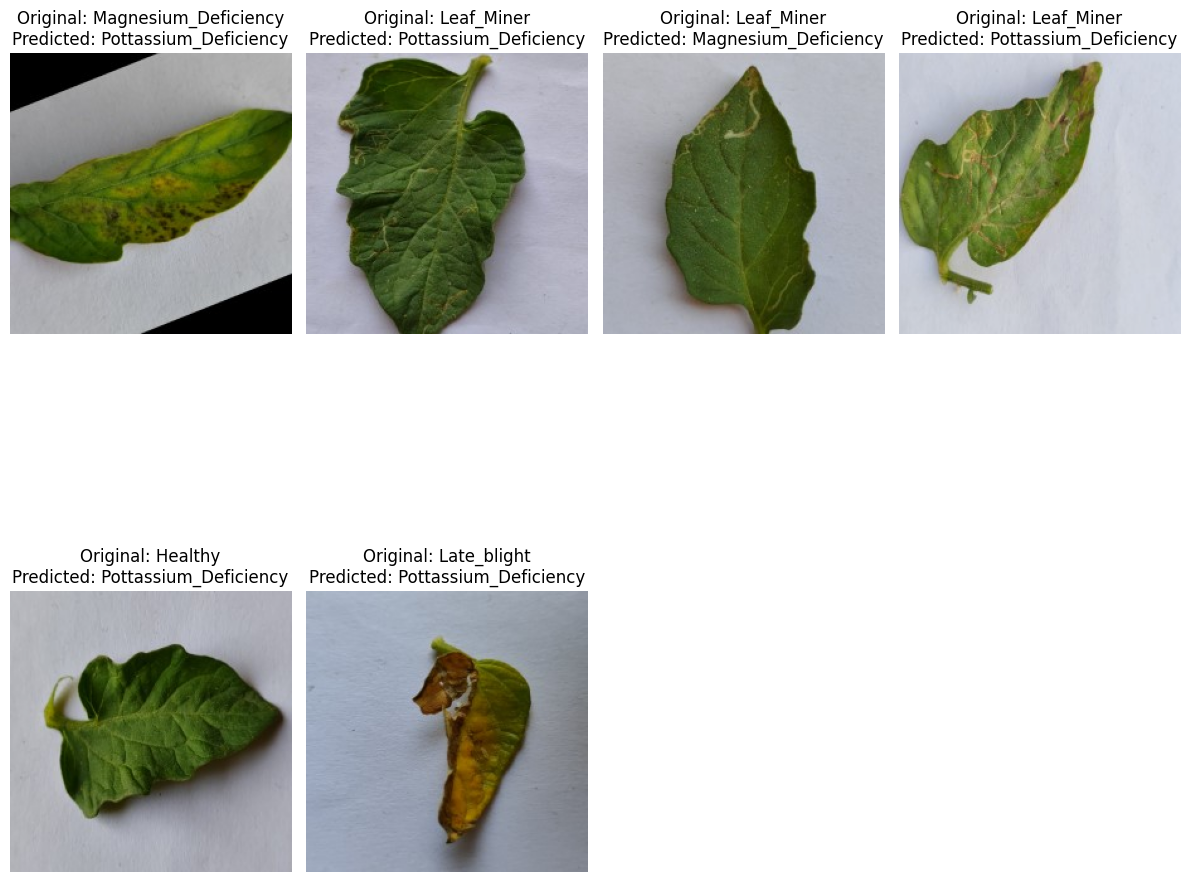

In [ ]:
def imshow(inp, ax):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.axis('off')


def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Initialize the figure

    num_rows = (num_images + 3) // 4  # Calculate rows for grid

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            for j in range(batch_size):
                # Check if the label and prediction are within the bounds of class_names
                if labels[j].item() >= len(class_names) or preds[j].item() >= len(class_names):
                    print(f"Skipping label {labels[j].item()} or prediction {preds[j].item()} as it is out of range")
                    continue  # Skip this image if it's out of bounds

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return fig  # Ensure a valid figure is returned

                images_so_far += 1
                row = (images_so_far - 1) // 4
                col = (images_so_far - 1) % 4

                ax = plt.subplot(num_rows, 4, images_so_far)
                ax.set_title(f'Original: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')

                imshow(inputs.cpu().data[j], ax)

        model.train(mode=was_training)

    plt.tight_layout()
    return fig


figure = visualize_model(model, dataloaders, class_names, num_images=6)





### Save Outputs


In [ ]:
folder = '/content/model_summaries'
pdf_name = f'{model.__class__.__name__}_summary.pdf'
pdf_path = os.path.join(folder, pdf_name)

# Ensure the folder exists
if not os.path.exists(folder):
    os.makedirs(folder)


def save_to_pdf(pdf, figure):
    pdf.savefig(figure)
    plt.close(figure)


def save_model_outputs_to_pdf(model, accuracy, figure):

    with PdfPages(pdf_path) as pdf:
        # Validation accuracy
        fig = plt.figure(figsize=(8, 4))
        plt.text(0.5, 0.5, f"Model: {model.__class__.__name__}\nValidation Accuracy: {accuracy:.2f}%",
                 horizontalalignment='center', verticalalignment='center', fontsize=18)
        plt.axis('off')
        save_to_pdf(pdf, fig)

        # Predictions visualization)
        save_to_pdf(pdf, figure)  # Save the figure visualizing predictions

    print(f"Model summary saved to {pdf_path}")


save_model_outputs_to_pdf(model, accuracy, figure)

Model summary saved to /content/model_summaries/ResNet_summary.pdf


# Save to GitHub folder




In [ ]:
git_path = f'/content/LPDI/server/model/model_summaries/{pdf_name}'
shutil.copy(pdf_path, git_path)

%cd /content/LPDI



/content/LPDI


### Save to local machine

In [ ]:
from google.colab import files
files.download(pdf_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>